# Credit Card Behaviour Score Prediction
### Forward-Looking Risk Classification using Financial Behavior Features

**Project Objective:**  
Predict whether a customer will default on their credit card payment in the next billing cycle, using anonymized behavioral and demographic data. This model aims to improve proactive risk management by highlighting high-risk customers.


## 1. Import Required Libraries

Importing all standard libraries for data analysis, modeling, visualization, and class imbalance handling.


In [2]:
# Basic Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Building & Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, fbeta_score, confusion_matrix, classification_report, roc_auc_score
)

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Imbalance Handling
from imblearn.over_sampling import SMOTE

# System Warnings
import warnings
warnings.filterwarnings('ignore')


## 2. Load Train and Validation Datasets

Loading the anonymized behavioral dataset for over 30,000 credit card customers. The dataset includes repayment history, bill amounts, payments, and demographic attributes.


In [3]:
# Load the datasets
train_df = pd.read_csv("train_dataset_final1.csv")
val_df = pd.read_csv("validate_dataset_final.csv")

# Check their shapes
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)

# Preview first few rows
train_df.head()


Train shape: (25247, 27)
Validation shape: (5016, 26)


,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,63.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


In [4]:
# Overview of training data
print("Training Columns:\n", train_df.columns.tolist())
print("\nMissing values per column:\n", train_df.isnull().sum())

# Check datatypes
print("\nData types:\n", train_df.dtypes)

# Value counts of target
print("\nTarget distribution:")
print(train_df['next_month_default'].value_counts())

# Percentage distribution of target
print("\nTarget class ratio (%):")
print(train_df['next_month_default'].value_counts(normalize=True) * 100)


Training Columns:
 ['Customer_ID', 'marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'next_month_default']

Missing values per column:
 Customer_ID             0
marriage                0
sex                     0
education               0
LIMIT_BAL               0
age                   126
pay_0                   0
pay_2                   0
pay_3                   0
pay_4                   0
pay_5                   0
pay_6                   0
Bill_amt1               0
Bill_amt2               0
Bill_amt3               0
Bill_amt4               0
Bill_amt5               0
Bill_amt6               0
pay_amt1                0
pay_amt2                0
pay_amt3                0
pay_amt4                0
pay_amt5                0
pay_amt6               

In [5]:
# Fill missing age values with median
train_df['age'].fillna(train_df['age'].median(), inplace=True)

# Confirm no nulls remain
print("Missing values after imputation:\n", train_df.isnull().sum().sum())


Missing values after imputation:
 0


### 3. Exploratory Data Analysis (EDA)

To understand the data, I first visualize the distributions of key demographic and financial variables, segmented by the default status.

The plots below analyze customer **Age** and **Credit Limit (`LIMIT_BAL`)**.

**Initial Observations:**

*   **Age:** Default risk appears slightly higher among younger customers (late 20s to early 40s).
*   **Credit Limit:** Default is most common among customers with lower credit limits (under 200,000). Customers with very high credit limits are significantly less likely to default, suggesting they are a lower-risk group.

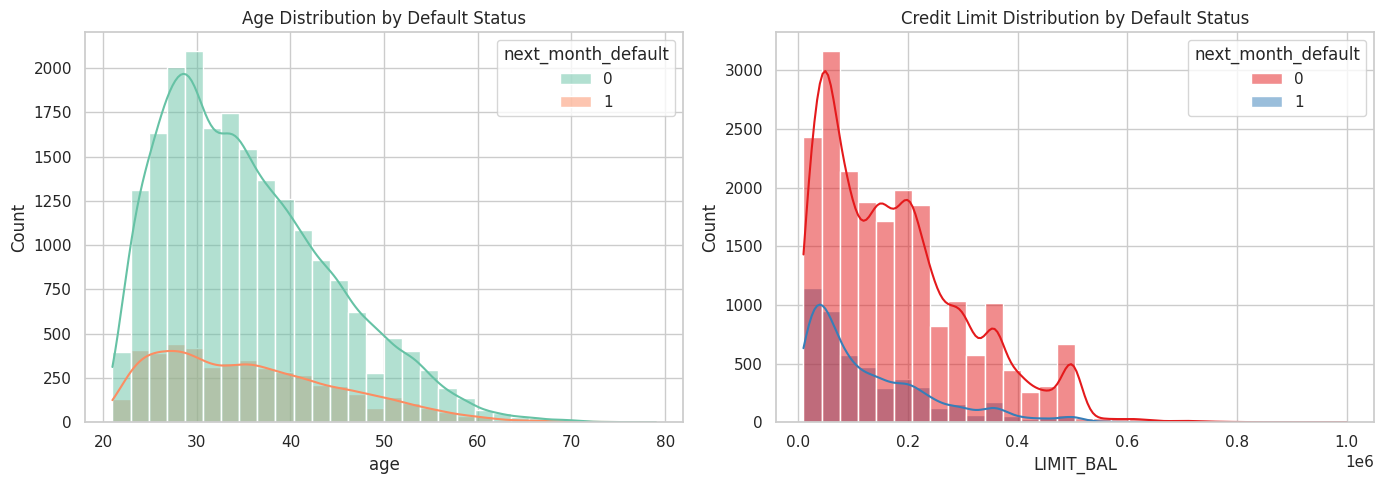

In [6]:
# Set plot style
sns.set(style="whitegrid")

# Plot distribution of age
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=train_df, x='age', hue='next_month_default', bins=30, kde=True, palette='Set2')
plt.title('Age Distribution by Default Status')

plt.subplot(1, 2, 2)
sns.histplot(data=train_df, x='LIMIT_BAL', hue='next_month_default', bins=30, kde=True, palette='Set1')
plt.title('Credit Limit Distribution by Default Status')

plt.tight_layout()
plt.show()


### 4. Analysis of Payment Status History

The `pay_` features represent the core behavioral data in this dataset. I visualize them using a boxplot to understand the relationship between payment delays and default status across the past six months.


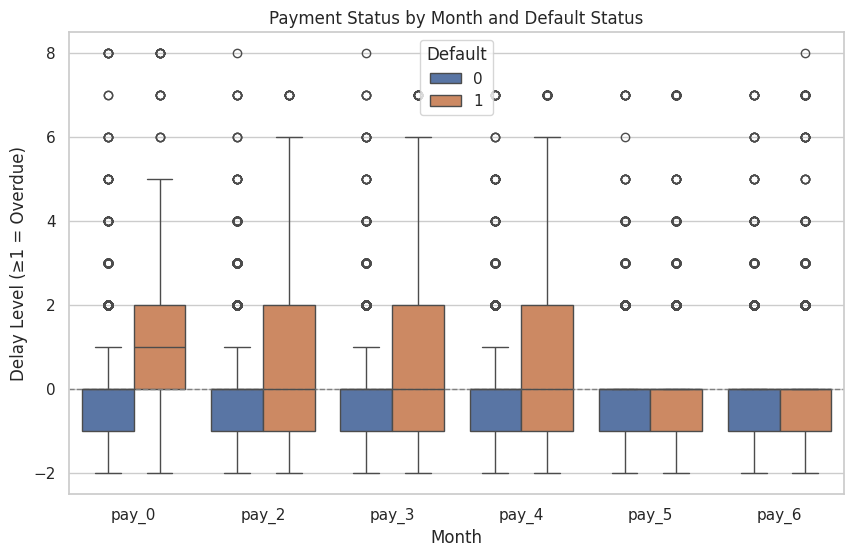

In [7]:
# Extract only payment status columns and the target
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
pay_df = train_df[pay_cols + ['next_month_default']]

# Melt into long format for lineplot
pay_melted = pay_df.melt(id_vars='next_month_default', var_name='Month', value_name='Status')

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=pay_melted, x='Month', y='Status', hue='next_month_default')
plt.title("Payment Status by Month and Default Status")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.ylabel("Delay Level (≥1 = Overdue)")
plt.legend(title='Default')
plt.show()



**Key Insights:**

*   **Clear Separation:** There is a distinct difference in payment behavior. Customers who **did not default (blue)** consistently have a median payment status of 0 (revolving credit) or below (paid on time).
*   **Default Behavior:** Customers who **did default (orange)** consistently show a median payment status of 1 or 2 months overdue, especially in the most recent months (`pay_0`, `pay_2`).
*   **Predictive Power:** The most recent payment status (`pay_0`) shows the clearest separation between the two groups, confirming its high importance as a predictor of near-term default.

### 5. Feature Engineering

To enhance the model's predictive power, I created several new features based on financial intuition. These features are designed to capture more complex behavioral patterns than the raw data alone.

My engineered features include:
*   **Averages & Ratios:** `AVG_Pay_amt`, `Utilization_Ratio`, `Pay_to_Limit`.
*   **Behavioral Patterns:** `Delinquency_Streak`, `Worst_Payment_Status`, `Repayment_Std`.
*   **Risk Indicators:** `Late_Payment_Sum`, `High_Delinquency`.

I created a function to apply these transformations consistently to both the training and validation datasets.

In [23]:
def feature_engineer(df):
    #Applying all feature engineering steps to the dataframe.
    # Define payment and bill columns for reuse
    pay_cols = [f'pay_{i}' for i in [0, 2, 3, 4, 5, 6]]
    pay_amt_cols = [f'pay_amt{i}' for i in range(1, 7)]
    bill_cols = [f'Bill_amt{i}' for i in range(1, 7)]

    # Feature: Average pay amount
    df['AVG_Pay_amt'] = df[pay_amt_cols].mean(axis=1)

    # Feature: Credit utilization (clip to 1 to handle cases where bill > limit)
    df['Utilization_Ratio'] = df['AVG_Bill_amt'] / df['LIMIT_BAL']
    df['Utilization_Ratio'] = df['Utilization_Ratio'].clip(upper=1)

    # Feature: Delinquency streak (number of months with delay >= 1)
    df['Delinquency_Streak'] = df[pay_cols].apply(lambda row: (row >= 1).sum(), axis=1)

    # Feature: Std deviation in repayment amounts
    df['Repayment_Std'] = df[pay_amt_cols].std(axis=1).fillna(0)

    # Feature: Total payments over credit limit
    df['Pay_to_Limit'] = df[pay_amt_cols].sum(axis=1) / df['LIMIT_BAL']

    # Feature: Residual balance ratio
    df['Residual_Balance'] = (df['AVG_Bill_amt'] - df['AVG_Pay_amt']) / df['LIMIT_BAL']

    # Feature: Overpayment frequency (count of negative bills)
    df['Overpay_Count'] = df[bill_cols].apply(lambda row: (row < 0).sum(), axis=1)

    # Feature: total number of months overdue (sum of delays)
    df['Late_Payment_Sum'] = df[pay_cols].apply(lambda r: sum(r[r >= 1]), axis=1)

    # Feature: binary flag for >=3 delayed months
    df['High_Delinquency'] = (df['Delinquency_Streak'] >= 3).astype(int)

    # Feature: worst single delay across months
    df['Worst_Payment_Status'] = df[pay_cols].max(axis=1)

    # Replace infinities from division by zero with a large number or zero
    df.replace([np.inf, -np.inf], 0, inplace=True)

    return df

# Apply the function to the training dataframe
print("Engineering features for train_df...")
train_df = feature_engineer(train_df.copy())
print("Done.")

Engineering features for train_df...
Done.


In [24]:
# Features to use
features = [
    'marriage', 'sex', 'education', 'LIMIT_BAL', 'age',
    'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'AVG_Pay_amt',
    'Utilization_Ratio', 'Delinquency_Streak', 'Repayment_Std',
    'Pay_to_Limit', 'Residual_Balance', 'Overpay_Count',
    'Late_Payment_Sum', 'High_Delinquency', 'Worst_Payment_Status'
] + pay_cols

target = 'next_month_default'

X = train_df[features]
y = train_df[target]

# Train-test split BEFORE applying SMOTE
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [25]:
# Apply SMOTE only on training data
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE - class distribution:")
print(pd.Series(y_train_res).value_counts())


After SMOTE - class distribution:
next_month_default
0    16352
1    16352
Name: count, dtype: int64


In [26]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

### 5. Building the Neural Network (MLP) Model

I am constructing a Multi-Layer Perceptron (MLP) using Keras as one of the candidate models. The architecture includes `Dropout` layers to prevent overfitting. I will train it on the scaled and SMOTE-resampled data, prioritizing **Recall** as a key metric during training to align with the goal of identifying defaulters.

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Define Model 1
mlp_model_1 = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile
mlp_model_1.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['Recall'])

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_1 = mlp_model_1.fit(
    X_train_scaled, y_train_res,
    validation_split=0.1,
    epochs=60,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - Recall: 0.5529 - loss: 0.6181 - val_Recall: 0.7163 - val_loss: 0.5449
Epoch 2/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Recall: 0.6556 - loss: 0.5287 - val_Recall: 0.7270 - val_loss: 0.5357
Epoch 3/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Recall: 0.6776 - loss: 0.5210 - val_Recall: 0.7291 - val_loss: 0.5158
Epoch 4/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Recall: 0.6626 - loss: 0.5152 - val_Recall: 0.7579 - val_loss: 0.4878
Epoch 5/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - Recall: 0.6817 - loss: 0.5063 - val_Recall: 0.7765 - val_loss: 0.4678
Epoch 6/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - Recall: 0.6813 - loss: 0.4932 - val_Recall: 0.7673 - val_loss: 0.4465
Epoch 7/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Recall: 0.6703 - loss: 0.4935 - val_Recall: 0.7490 - val_loss: 0.4638
Epoch 8/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - Recall: 0.6837 - loss: 0.4795 - val_Recall: 0.7943 - val_loss: 0.4122
Epoch 9

### MLP Evaluation & Threshold Optimization

Next, I evaluate the trained MLP on the unseen test data. To align with the business goal of prioritizing recall, I am searching for the optimal classification threshold that yields the highest F2-score.

In [28]:
from sklearn.metrics import fbeta_score, classification_report, confusion_matrix

# Predict on test
probs_1 = mlp_model_1.predict(X_test_scaled).flatten()

# Threshold sweep
thresholds = np.arange(0.1, 0.91, 0.01)
f2_scores_1 = []

for t in thresholds:
    preds = (probs_1 >= t).astype(int)
    f2 = fbeta_score(y_test, preds, beta=2)
    f2_scores_1.append(f2)

# Best threshold
best_idx_1 = np.argmax(f2_scores_1)
best_thresh_1 = thresholds[best_idx_1]
best_f2_1 = f2_scores_1[best_idx_1]

print(f"📈 Model 1 → Best Threshold: {best_thresh_1:.2f}, F2 Score: {best_f2_1:.4f}")


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📈 Model 1 → Best Threshold: 0.19, F2 Score: 0.5853


In [29]:
final_preds_1 = (probs_1 >= best_thresh_1).astype(int)
print("\n📊 Model 1 Classification Report:")
print(classification_report(y_test, final_preds_1))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_preds_1))



📊 Model 1 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.40      0.55      4088
           1       0.25      0.87      0.39       962

    accuracy                           0.49      5050
   macro avg       0.59      0.63      0.47      5050
weighted avg       0.80      0.49      0.52      5050

Confusion Matrix:
 [[1615 2473]
 [ 124  838]]


## 6. Model Comparison

To select the best algorithm for this task, we will compare three different models:
1.  **Logistic Regression:** A simple, interpretable linear model that serves as a strong baseline.
2.  **MLP (Neural Network):** The model we have already built.
3.  **XGBoost:** A powerful gradient boosting algorithm known for its high performance on tabular data.

We will train each model on the SMOTE-resampled training data and evaluate them using the **F2 Score** on the unseen test set. For each model, we will perform a threshold sweep to find its optimal F2 score.

In [30]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, fbeta_score
import pandas as pd

# Define the models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "MLP (Keras)": mlp_model_1, # Your already trained MLP model
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []
thresholds = np.arange(0.1, 0.91, 0.01)

# Loop through each model for training and evaluation
for name, model in models.items():
    print(f"--- Training and Evaluating {name} ---")

    if name != "MLP (Keras)": # Keras model is already trained
        # Note: XGBoost and Logistic Regression are trained on scaled data for consistency
        model.fit(X_train_scaled, y_train_res)
        probs = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # For the Keras model, we use the already computed probabilities
        probs = probs_1

    # Threshold sweep to find the best F2 score
    f2_scores = [fbeta_score(y_test, (probs >= t).astype(int), beta=2) for t in thresholds]
    best_idx = np.argmax(f2_scores)
    best_threshold = thresholds[best_idx]
    best_f2 = f2_scores[best_idx]

    # Get other metrics at the best threshold
    final_preds = (probs >= best_threshold).astype(int)
    recall = recall_score(y_test, final_preds)
    precision = precision_score(y_test, final_preds)
    accuracy = accuracy_score(y_test, final_preds)

    results.append({
        "Model": name,
        "Best F2 Score": best_f2,
        "Optimal Threshold": best_threshold,
        "Recall": recall,
        "Precision": precision,
        "Accuracy": accuracy
    })

# Display the results in a clean DataFrame
results_df = pd.DataFrame(results).sort_values(by="Best F2 Score", ascending=False)
print("\n--- Model Comparison Results ---")
print(results_df.to_string())

--- Training and Evaluating Logistic Regression ---
--- Training and Evaluating MLP (Keras) ---
--- Training and Evaluating XGBoost ---

--- Model Comparison Results ---
                 Model  Best F2 Score  Optimal Threshold    Recall  Precision  Accuracy
2              XGBoost       0.591483               0.15  0.779626   0.300963  0.613069
1          MLP (Keras)       0.585277               0.19  0.871102   0.253096  0.485743
0  Logistic Regression       0.561232               0.27  0.810811   0.251532  0.504356


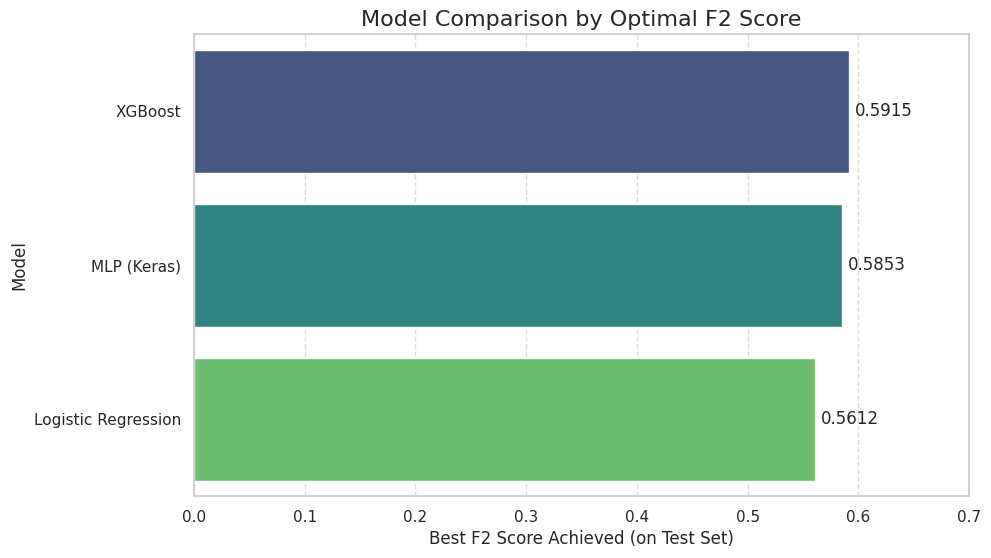

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the results dataframe is sorted by F2 Score for a clean plot
results_df_sorted = results_df.sort_values(by="Best F2 Score", ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x="Best F2 Score",
    y="Model",
    data=results_df_sorted,
    palette='viridis',
    orient='h' # Horizontal bar plot
)

# Add labels on top of the bars for clarity
for p in ax.patches:
    width = p.get_width()
    plt.text(
        width + 0.005,  # Position of the text
        p.get_y() + p.get_height() / 2,
        f'{width:.4f}',  # Format the F2 score to 4 decimal places
        va='center'
    )

# Set titles and labels
plt.title('Model Comparison by Optimal F2 Score', fontsize=16)
plt.xlabel('Best F2 Score Achieved (on Test Set)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0, 0.7) # Adjust x-axis limit if needed
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## 7. Hyperparameter Tuning for XGBoost

The initial comparison shows that XGBoost is the most promising model. We will now use `GridSearchCV` to find the optimal hyperparameters for XGBoost, specifically optimizing for the F2 score.

**Note:** Since tree-based models like XGBoost are not sensitive to feature scaling, we will use the unscaled, SMOTE-resampled training data (`X_train_res`, `y_train_res`) for this step to maintain feature interpretability.

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Define the F2 scorer for GridSearchCV
f2_scorer = make_scorer(fbeta_score, beta=2)

# Define a smaller, faster parameter grid for tuning
# You can expand this for a more exhaustive search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# IMPORTANT: Since y_train_res is balanced, we DO NOT use scale_pos_weight here.
xgb_tuned = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_tuned,
    param_grid=param_grid,
    scoring=f2_scorer,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1, # Use all available CPU cores
    verbose=2
)

print("--- Starting Hyperparameter Tuning for XGBoost ---")
# Use the unscaled but SMOTE-resampled data for tuning
grid_search.fit(X_train_res, y_train_res)

print(f"\n✅ Best Parameters found: {grid_search.best_params_}")
print(f"✅ Best Cross-Validated F2 Score: {grid_search.best_score_:.4f}")

# Get the best model from the grid search
best_xgb_model = grid_search.best_estimator_

--- Starting Hyperparameter Tuning for XGBoost ---
Fitting 3 folds for each of 32 candidates, totalling 96 fits

✅ Best Parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
✅ Best Cross-Validated F2 Score: 0.7606


## 8. Final Model Evaluation

Now, we evaluate our final, tuned XGBoost model on the unseen test set. We will again perform a threshold sweep to find the optimal cutoff that maximizes the F2 score on the test data.

In [32]:
# Predict probabilities on the original (unscaled) test set
final_probs = best_xgb_model.predict_proba(X_test)[:, 1]

# Threshold sweep
final_f2_scores = [fbeta_score(y_test, (final_probs >= t).astype(int), beta=2) for t in thresholds]
final_best_idx = np.argmax(final_f2_scores)
final_best_threshold = thresholds[final_best_idx]
final_best_f2 = final_f2_scores[final_best_idx]

print(f"📈 Tuned XGBoost → Best Threshold: {final_best_threshold:.2f}, Final Test F2 Score: {final_best_f2:.4f}")

# Final predictions and report
final_tuned_preds = (final_probs >= final_best_threshold).astype(int)

print("\n📊 Final Tuned XGBoost Classification Report:")
print(classification_report(y_test, final_tuned_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_tuned_preds))

📈 Tuned XGBoost → Best Threshold: 0.14, Final Test F2 Score: 0.5901

📊 Final Tuned XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.52      0.67      4088
           1       0.29      0.81      0.42       962

    accuracy                           0.58      5050
   macro avg       0.60      0.67      0.54      5050
weighted avg       0.80      0.58      0.62      5050

Confusion Matrix:
 [[2144 1944]
 [ 187  775]]


## 7. Model Interpretation with SHAP

To understand *why* the model makes certain predictions, we use SHAP (SHapley Additive exPlanations). This helps explain which features are the most influential drivers of default risk.

We train a simple XGBoost model on the original, unscaled data purely for this explainability step. This ensures the feature impacts are easy to interpret.

The summary plot below ranks features by their importance and visualizes the impact of each feature's value on the model's output.

- **Red dots** indicate high feature values.
- **Blue dots** indicate low feature values.
- **Positive SHAP values** (to the right) increase the prediction towards default.
- **Negative SHAP values** (to the left) decrease the prediction towards default.

In [33]:
from xgboost import XGBClassifier

# Retrain XGBoost just for SHAP visualization
xgb_shap_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=4.25, random_state=42)
xgb_shap_model.fit(X_train, y_train)  # No scaling or SMOTE here!


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

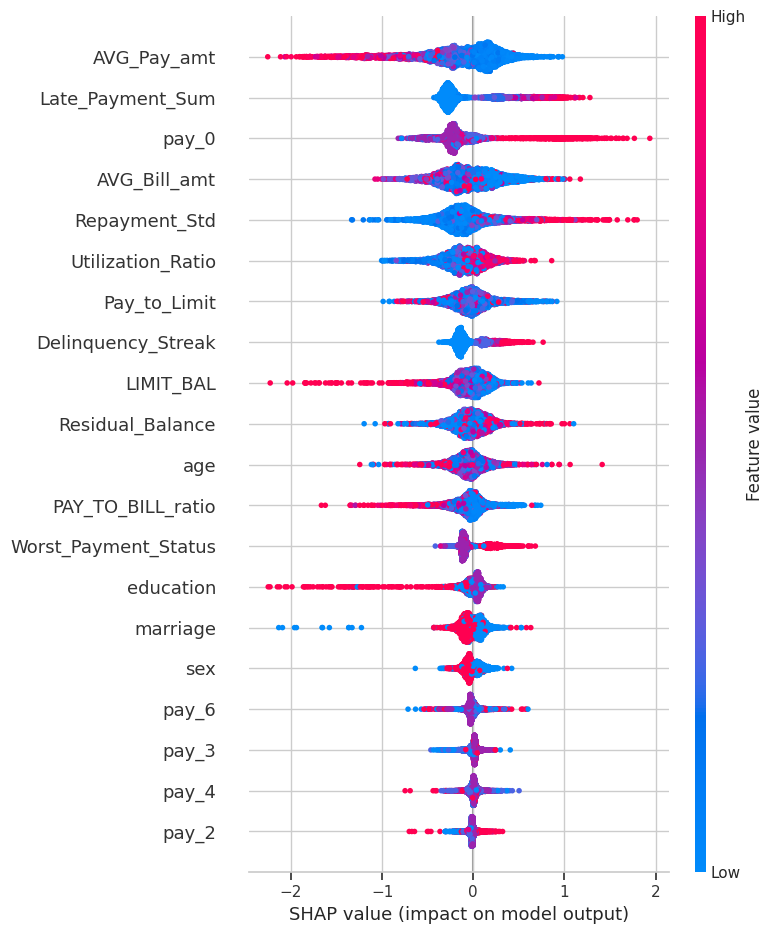

In [34]:
import shap

# SHAP explainer
explainer = shap.TreeExplainer(xgb_shap_model)

# Use unscaled X_test
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


In [35]:
# Step 1: Apply the SAME feature engineering to the validation set
print("Engineering features for val_df...")
val_df_engineered = feature_engineer(val_df.copy())
print("Done.")

# Step 2: Prepare validation features using the engineered validation data
# The best model (XGBoost) was tuned on unscaled data.
X_val_final = val_df_engineered[features] # Ensure 'features' is the same list of columns

# Step 3: Predict probabilities using the tuned XGBoost model
val_probs_final = best_xgb_model.predict_proba(X_val_final)[:, 1]

# Step 4: Apply the optimal threshold found for the tuned XGBoost model
final_best_threshold = 0.14 # Using the threshold I found previously
val_preds_final = (val_probs_final >= final_best_threshold).astype(int)

# Step 5: Create submission DataFrame
submission_df = pd.DataFrame({
    'Customer': val_df['Customer_ID'], # Use original val_df for Customer_ID
    'next_month_default': val_preds_final
})

# Step 6: Export as CSV
submission_df.to_csv('submission_22116008.csv', index=False)
print("\n✅ Final predictions saved to 'submission_22116008.csv' using the tuned XGBoost model.")

# Display the distribution of predictions
print("\nPrediction distribution in submission file:")
print(submission_df['next_month_default'].value_counts(normalize=True) * 100)

Engineering features for val_df...
Done.

✅ Final predictions saved to 'submission_22116008.csv' using the tuned XGBoost model.

Prediction distribution in submission file:
next_month_default
1    54.864434
0    45.135566
Name: proportion, dtype: float64
